In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

from cert_collective.cert_collective import collective_certificate_grid
from cert_collective.utils import gcn_receptive_field_mask

In [125]:
plt.rcParams['figure.figsize'] = [8,5]

In [4]:
def load_npz(file_name):
    """Load a SparseGraph from a Numpy binary file.
    Parameters
    ----------
    file_name : str
        Name of the file to load.
    Returns
    -------
    sparse_graph : gust.SparseGraph
        Graph in sparse matrix format.
    """
    if not file_name.endswith(".npz"):
        file_name += ".npz"
    with np.load(file_name, allow_pickle=True) as loader:
        loader = dict(loader)
        adj_matrix = sp.sparse.csr_matrix(
            (loader["adj_data"], loader["adj_indices"], loader["adj_indptr"]),
            shape=loader["adj_shape"],
        )

        if "attr_data" in loader:
            attr_matrix = sp.sparse.csr_matrix(
                (
                    loader["attr_data"],
                    loader["attr_indices"],
                    loader["attr_indptr"],
                ),
                shape=loader["attr_shape"],
            )
        else:
            attr_matrix = None

        labels = loader.get("labels")

    return adj_matrix, attr_matrix, labels

## Load graph and base certificate

In [30]:
graph = np.load('data/graphs/cora_ml.npz', allow_pickle=True)

# Pair of binary scipy sparse matrices
print(graph.keys())
attr = graph['attr'][()] 
adj = graph['adj'][()]
n_nodes = attr.shape[0]

base_cert_grid = np.load('data/base_certs/cora_ml/attr_grid.npy')

KeysView(NpzFile 'data/graphs/cora_ml.npz' with keys: attr, adj)


In [186]:
dataset = "pubmed"
mode = 'add'
approach = 'optim'

adj, attr, _ = load_npz(f'data/graphs/{dataset}_old.npz')
n_nodes = attr.shape[0]

if approach == 'poly':
    base_cert_grid = np.load(f'data/base_certs/{dataset}_{approach}_attr_{mode}.npy')
else:
    base_cert_grid = np.load(f'data/base_certs/{dataset}_{approach}_attr.npy')
    if mode == 'add':
        base_cert_grid = base_cert_grid.transpose(0, 2, 1)

In [187]:
base_cert_grid.shape

(19717, 201, 1)

Text(0.5, 1.0, 'Base certificate')

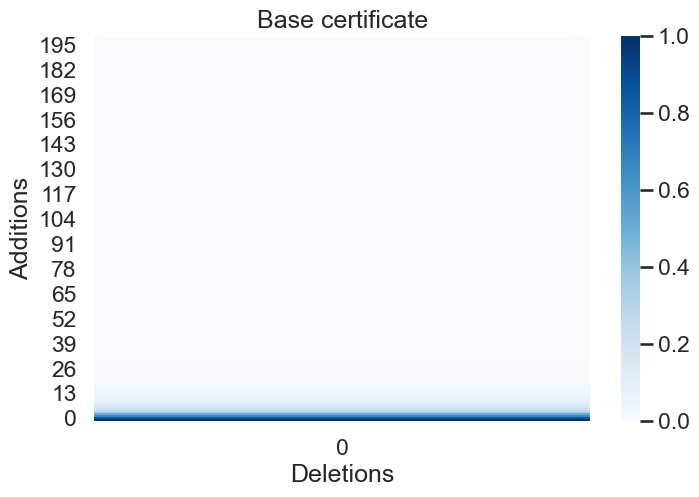

In [188]:
heatmap = base_cert_grid.mean(0)
sns.set_context('talk')
sns.heatmap(heatmap, 
            cmap='Blues',
            vmin=0, vmax=1)

plt.xlim(0, heatmap.shape[1])
plt.ylim(0, heatmap.shape[0])
plt.xlabel('Deletions')
plt.ylabel('Additions')
plt.title('Base certificate')

## Specify base cert dimensions and receptive fields

In [189]:
print(base_cert_grid.shape)

dim_labels = ['attr_add', 'attr_del']

n_layers = 2
# List of binary sparse matrices
receptive_field_masks = [gcn_receptive_field_mask(adj, dim_label, n_layers, n_nodes)
                         for dim_label in dim_labels]

(19717, 201, 1)


In [190]:
print(f'Istalled solvers: {cp.installed_solvers()}')

solver = 'GUROBI'

Istalled solvers: ['ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


## Attribute additions

In [191]:
collective_grid_add = collective_certificate_grid(
    base_cert_grid, dim_labels, receptive_field_masks, attr, adj, max_rad=[0, 1000, 0], rad_stepsize=np.array([1, 20, 1]),
    solver=solver
)[0, :, 0]

100%|██████████| 51/51 [1:05:39<00:00, 77.24s/it]


In [192]:
collective_grid_add

array([19717, 14791, 12948, 11747, 10865, 10156,  9548,  9034,  8588,
        8194,  7837,  7513,  7216,  6940,  6683,  6443,  6216,  6001,
        5799,  5609,  5430,  5261,  5100,  4946,  4799,  4657,  4522,
        4391,  4267,  4148,  4034,  3924,  3818,  3717,  3619,  3525,
        3433,  3346,  3261,  3180,  3101,  3024,  2950,  2877,  2807,
        2738,  2672,  2608,  2545,  2485,  2426])

In [193]:
x_axis = range(0, 1001, 20)

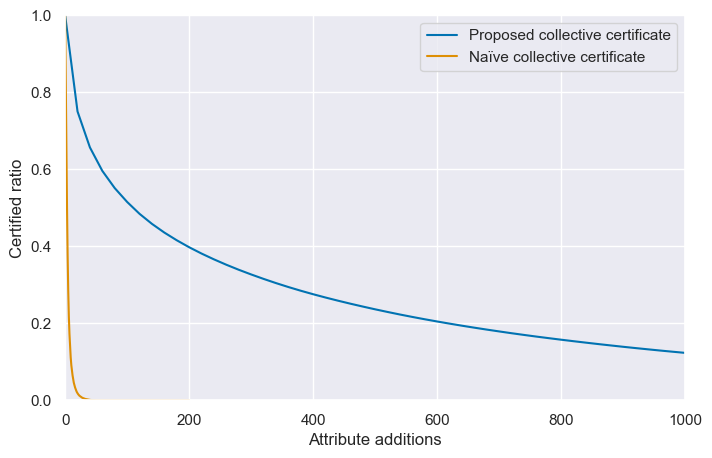

In [194]:
sns.set()
pal = sns.color_palette('colorblind', 2)

plt.plot(x_axis, collective_grid_add / n_nodes, color=pal[0], label='Proposed collective certificate')
plt.plot(base_cert_grid.mean(axis=0)[:, 0], color=pal[1], label='Naïve collective certificate')

plt.legend()
plt.xlabel('Attribute additions')
plt.ylabel('Certified ratio')
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.savefig('figures/cora_attr_add.png', bbox_inches='tight')

In [195]:
results = {}
results['collective_add'] = collective_grid_add / n_nodes
results['base_result'] = base_cert_grid.mean(axis=0)[:, 0]
results['collective_x_axis'] = x_axis

np.save(f'results/{approach}/{dataset}_attr_{mode}.npy', results)

In [196]:
base_cert_grid.shape

(19717, 201, 1)

In [45]:
a = np.load(f'results/{dataset}_attr_del.npy', allow_pickle=True)[()]

## Attribute deletions

In [182]:
collective_grid_del = collective_certificate_grid(
    base_cert_grid, dim_labels, receptive_field_masks, attr, adj, max_rad=[0, 0, 1000], rad_stepsize=np.array([1, 1, 20]),
    solver=solver
)[0, 0, :]

100%|██████████| 51/51 [1:06:06<00:00, 77.78s/it]


In [183]:
x_axis = range(0, 1001, 20)

(0.0, 1.0)

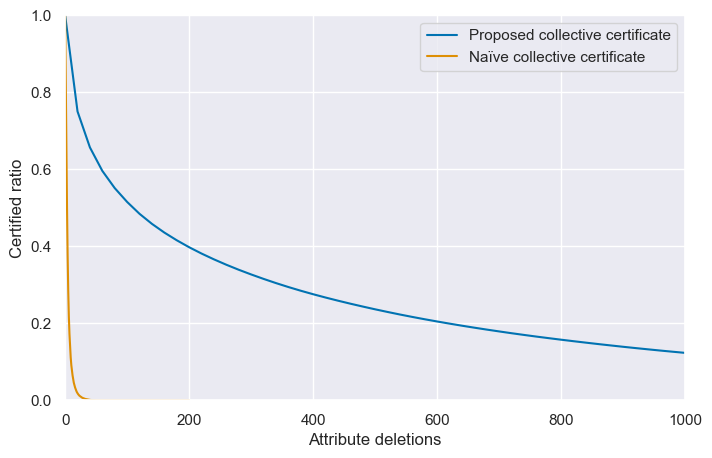

In [184]:
sns.set()
pal = sns.color_palette('colorblind', 2)

plt.plot(x_axis, collective_grid_del / n_nodes, color=pal[0], label='Proposed collective certificate')
plt.plot(base_cert_grid.mean(axis=0)[0, :], color=pal[1], label='Naïve collective certificate')

plt.legend()
plt.xlabel('Attribute deletions')
plt.ylabel('Certified ratio')
plt.xlim(0, 1000)
plt.ylim(0, 1)

In [185]:
results = {}
results['collective_del'] = collective_grid_del / n_nodes
results['base_result'] = base_cert_grid.mean(axis=0)[0, :]
results['collective_x_axis'] = x_axis

np.save(f'results/{approach}/{dataset}_attr_{mode}.npy', results)

In [176]:
a = np.load(f'results/{approach}/{dataset}_attr_{mode}.npy', allow_pickle=True)[()]

## Local constraints and limited attacker-controlled nodes

In [ ]:
collective_grid_del_local = collective_certificate_grid(
    base_cert_grid, dim_labels, receptive_field_masks, attr, adj, max_rad=[0, 0, 32],
    local_budget_descriptor=np.array([0, 0, 4]), local_budget_mode='absolute', num_attackers=6,
    solver=solver
)[0, 0, :]

In [ ]:
sns.set()
pal = sns.color_palette('colorblind', 2)
plt.plot(collective_grid_del_local / n_nodes, color=pal[0], label='Collective certificate w/ local constraints')
plt.plot(base_cert_grid.mean(axis=0)[0, :], color=pal[1], label='Naïve collective certificate')
plt.legend()
plt.xlabel('Attribute deletions')
plt.ylabel('Certified ratio')
plt.xlim(0, 32)
plt.ylim(0, 1)